In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input
import tensorflow as tf
import os

IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

ai_dir = 'AI-face-detection-Dataset/AI'
real_dir = 'AI-face-detection-Dataset/real'

In [3]:
def resize_image(image, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    return tf.image.resize(image, target_size)

def normalize_image(image):
    return image / 255.0

def preprocess_image(image, label):
    image = resize_image(image)
    image = normalize_image(image)
    return image, label

def load_dataset(data_dir, label):
    images = []
    labels = []
    
    for image_name in os.listdir(data_dir):
        if image_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(data_dir, image_name)
            image = tf.io.read_file(image_path)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
            image = image / 255.0
            images.append(image)
            labels.append(label)
            
    return tf.data.Dataset.from_tensor_slices((images, labels))

In [4]:
ai_dataset = load_dataset(ai_dir, 0)
real_dataset = load_dataset(real_dir, 1)

full_dataset = ai_dataset.concatenate(real_dataset).shuffle(1000).prefetch(tf.data.AUTOTUNE)

In [5]:
train_size = int(0.7 * full_dataset.cardinality().numpy())
val_size = int(0.15 * full_dataset.cardinality().numpy())
test_size = full_dataset.cardinality().numpy() - train_size - val_size

train_dataset = full_dataset.take(train_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
remaining_dataset = full_dataset.skip(train_size)
val_dataset = remaining_dataset.take(val_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = remaining_dataset.skip(val_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [6]:
model = tf.keras.Sequential([
    # Input layer and first convolutional layer
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Second convolutional layer
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Third convolutional layer
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Flatten the output
    tf.keras.layers.Flatten(),
    
    # Fully connected layers
    tf.keras.layers.Dense(128, activation='relu'),
    
    # Output layer
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

C:\Users\rcand\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset
)

Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 39s 517ms/step - accuracy: 0.8352 - loss: 0.5207 - val_accuracy: 0.9917 - val_loss: 0.0158
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 36s 513ms/step - accuracy: 0.9922 - loss: 0.0233 - val_accuracy: 1.0000 - val_loss: 2.5212e-04
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 36s 512ms/step - accuracy: 0.9954 - loss: 0.0085 - val_accuracy: 0.9979 - val_loss: 0.0019
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 36s 508ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 1.0000 - val_loss: 1.7926e-04
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 37s 515ms/step - accuracy: 1.0000 - loss: 3.5876e-04 - val_accuracy: 1.0000 - val_loss: 1.1329e-04
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 36s 508ms/step - accuracy: 0.9970 - loss: 0.0065 - val_accuracy: 1.0000 - val_loss: 9.1208e-05
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 36s 509ms/step - accuracy: 0.9949 - loss: 0.0195 - val_accuracy: 0.9937 - val_loss: 0.0171
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 36s 512ms/step - accuracy: 0.9875 - los

In [8]:
test_loss, test_acc = model.evaluate(test_dataset)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 1.8535e-06


In [9]:
print(test_loss)
print(test_acc)

7.4877484621538315e-06
1.0


In [10]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

def evaluate_model(model, test_dataset):
    y_true = []
    y_pred = []

    for images, labels in test_dataset:
        predictions = model.predict(images)
        predicted_classes = (predictions > 0.5).astype(int).flatten()
        y_true.extend(labels.numpy())
        y_pred.extend(predicted_classes)

    return np.array(y_true), np.array(y_pred)

y_true, y_pred = evaluate_model(model, test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


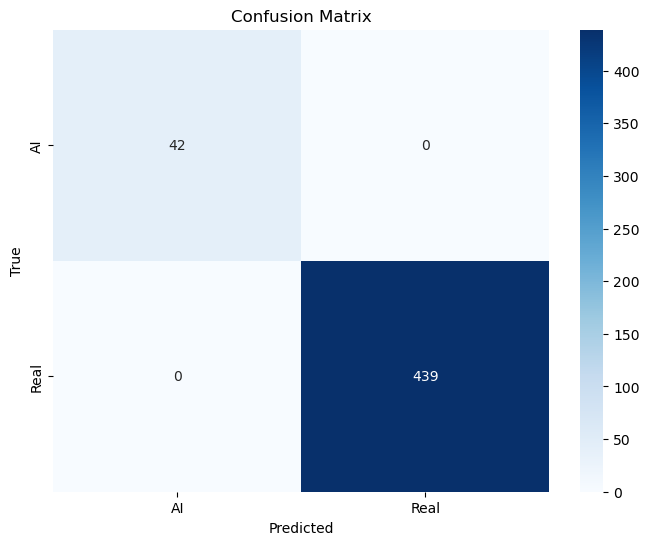

[[ 42   0]
 [  0 439]]


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print(cm)

plot_confusion_matrix(y_true, y_pred, class_names=['AI', 'Real'])

In [18]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping

def lr_schedule(epoch, lr):
    initial_lr = 0.001
    decay_rate = 0.9
    return initial_lr * (decay_rate ** epoch)
    
opt_model = tf.keras.Sequential([
    # Input layer and first convolutional layer
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    # Second convolutional layer
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    # Third convolutional layer
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    # Flatten the output
    tf.keras.layers.Flatten(),
    
    # Fully connected layers
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    
    # Output layer
    tf.keras.layers.Dense(1, activation='sigmoid')
])

lr_scheduler = LearningRateScheduler(lr_schedule)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

opt_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = opt_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.9242 - loss: 9.8634 - val_accuracy: 0.8854 - val_loss: 36.9676 - learning_rate: 0.0010
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.9706 - loss: 0.6793 - val_accuracy: 0.9104 - val_loss: 71.7928 - learning_rate: 9.0000e-04
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.9724 - loss: 1.9153 - val_accuracy: 0.8625 - val_loss: 35.2942 - learning_rate: 8.1000e-04
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.9906 - loss: 0.0180 - val_accuracy: 0.8938 - val_loss: 37.5734 - learning_rate: 7.2900e-04
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.9928 - loss: 0.0475 - val_accuracy: 0.9250 - val_loss: 4.8689 - learning_rate: 6.5610e-04
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.9990 - loss: 0.0021 - val_accuracy: 0.9875 - val_loss: 0.2421 - learning_rate: 5.9049e-04
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.9942 

In [22]:
test_loss, test_acc = opt_model.evaluate(test_dataset)
print(test_loss)
print(test_acc)

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.9984 - loss: 0.0708
0.09331157058477402
0.9979209899902344


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


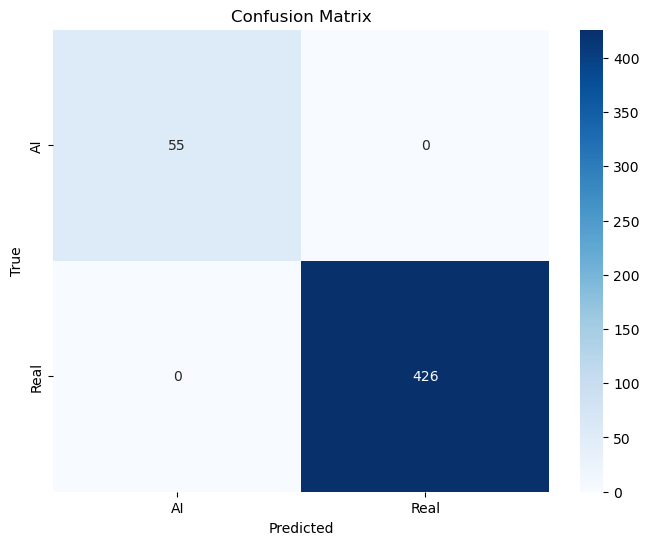

[[ 55   0]
 [  0 426]]


In [21]:
y_true, y_pred = evaluate_model(opt_model, test_dataset)

plot_confusion_matrix(y_true, y_pred, class_names=['AI', 'Real'])